# Dissimilar edges and negative weights

In this notebook, we show how the number of repulsive edges and the magnitude of the negative weights
can affect the embeddings, when creating embeddings based on weights. We use MNIST as a case study.

The summary of what we'll find: the more dissimilar edges (and the larger the magnitude of the negative weight), the more uniformly spread out the embedding is. The fewer edges (and the smaller the magnitude of the weight), the more tightly clustered the embedding is. These comments are for when a standardization constraint is enforced. Without the constraint, the embedding can collapse to 0 if there are too few dissimilar edges.

You should make sure to look at the MNIST notebook before going through this one.

In [1]:
import pymde

import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
mnist = pymde.datasets.MNIST()

images = mnist.data
digits = mnist.attributes['digits']

In [3]:
knn_graph = pymde.preprocess.k_nearest_neighbors(images, k=15, verbose=True)

Wed Feb  3 16:49:56 2021 Building RP forest with 21 trees
Wed Feb  3 16:49:59 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations


### Quadratic MDE problem

We start by computing a spectral initialization.

In [4]:
quadratic_mde = pymde.MDE(
    n_items=images.shape[0],
    embedding_dim=2,
    edges=knn_graph.edges,
    distortion_function=pymde.penalties.Quadratic(knn_graph.weights),
    constraint=pymde.Standardized())
quadratic_mde.embed(verbose=True)

Feb 03 04:50:12 PM: Fitting a standardized embedding into R^2, for a graph with 70000 items and 776339 edges.
Feb 03 04:50:12 PM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Feb 03 04:50:12 PM: iteration 000 | distortion 5.401135 | residual norm 0.0114814 | step length 9656.68 | percent change 29.6318
Feb 03 04:50:13 PM: iteration 030 | distortion 0.086687 | residual norm 0.000310505 | step length 1 | percent change 3.72937
Feb 03 04:50:14 PM: iteration 060 | distortion 0.059074 | residual norm 0.000330357 | step length 1 | percent change 5.6885
Feb 03 04:50:15 PM: iteration 090 | distortion 0.053951 | residual norm 9.13971e-05 | step length 1 | percent change 2.72604
Feb 03 04:50:17 PM: iteration 120 | distortion 0.051755 | residual norm 0.000169196 | step length 1 | percent change 6.53038
Feb 03 04:50:18 PM: iteration 150 | distortion 0.045695 | residual norm 0.000110019 | step length 1 | percent change 2.79065
Feb 03 04:50:19 PM: iteration 180 | distortion 0

tensor([[-0.1107, -0.1898],
        [-2.3644,  0.0204],
        [ 0.5832,  1.7532],
        ...,
        [ 0.8400,  1.2224],
        [ 0.0282, -0.1635],
        [-1.4237, -0.2948]])

<AxesSubplot:>

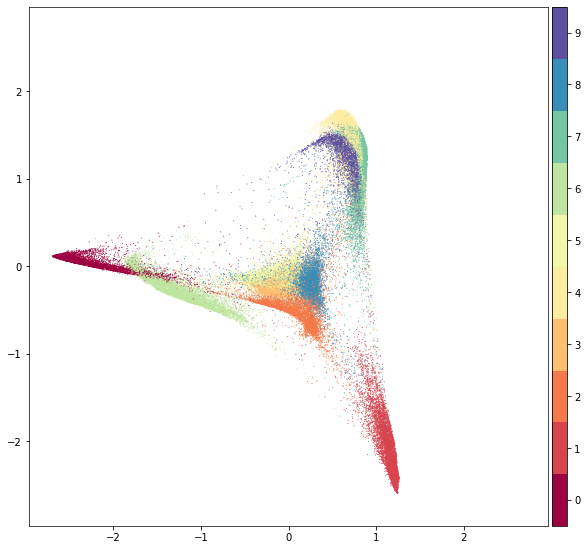

In [5]:
quadratic_mde.plot(color_by=digits)

## Dissimilar edges

First we vary the number of dissimilar edges, and show what effect this has on the embedding.

In [6]:
def get_edges(n_dissimilar_edges, neg_weight=-1.):
    similar_edges = knn_graph.edges

    dissimilar_edges = pymde.preprocess.dissimilar_edges(
        images.shape[0], num_edges=n_dissimilar_edges, similar_edges=similar_edges)

    edges = torch.cat([similar_edges, dissimilar_edges])
    weights = torch.cat([knn_graph.weights, neg_weight*torch.ones(dissimilar_edges.shape[0])])
    return edges, weights

# dissimilar edges / total:  0.11111480061235543


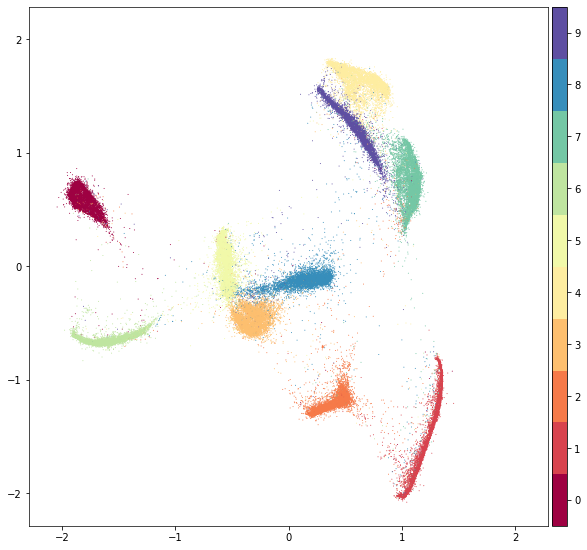

# dissimilar edges / total:  0.20001401553250778


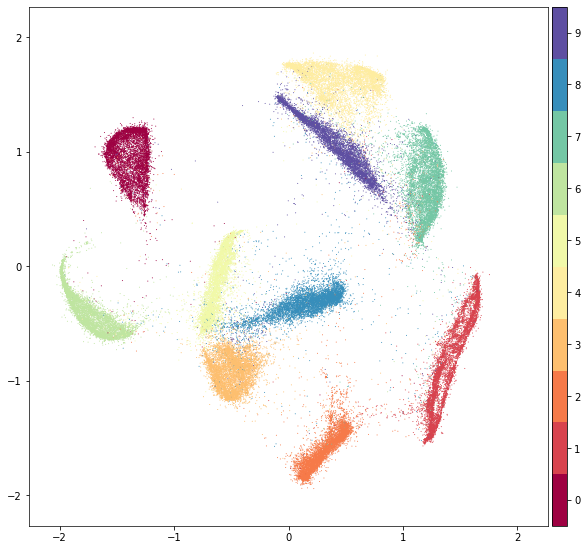

# dissimilar edges / total:  0.33337226708669315


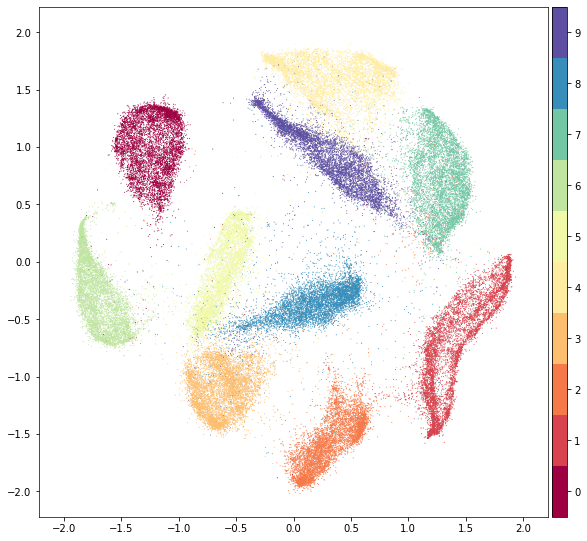

# dissimilar edges / total:  0.5000830960693626


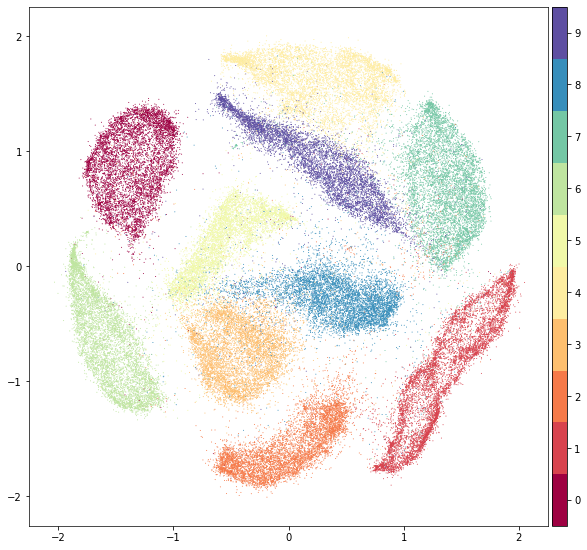

# dissimilar edges / total:  0.6668032329270702


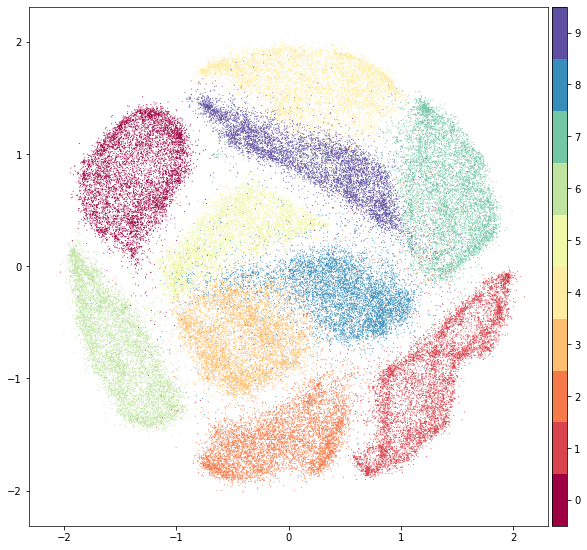

# dissimilar edges / total:  0.8001968696691868


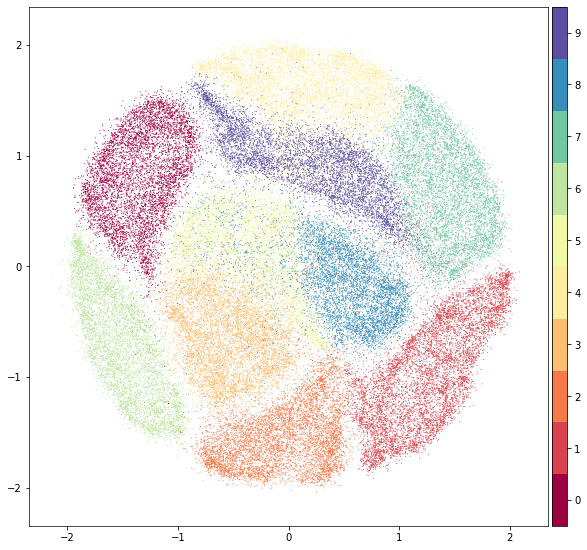

In [7]:
n_similar = knn_graph.edges.shape[0]
n_dissimilar = [
    n_similar // 8,
    n_similar // 4,
    n_similar // 2,
    n_similar,
    2*n_similar,
    4*n_similar,
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
for n_dissimilar_edges in n_dissimilar:
    
    edges, weights = get_edges(n_dissimilar_edges)
    print('# dissimilar edges / total: ', n_dissimilar_edges / edges.shape[0])
    f = pymde.penalties.PushAndPull(
        weights=weights,
        attractive_penalty=pymde.penalties.Log1p,
        repulsive_penalty=pymde.penalties.Log,
    ).to(device)
    std_mde = pymde.MDE(
        n_items=images.shape[0],
        embedding_dim=2,
        edges=edges.to(device),
        distortion_function=f,
        constraint=pymde.Standardized(),
    )
    std_mde.embed(X=quadratic_mde.X.to(device))
    std_mde.plot(color_by=digits)
    plt.show()

## Negative weights

Next we vary the weights instead of the number of edges. The effect is similar to what happened when we varied the dissimilar edges.

negative weight:  -0.125


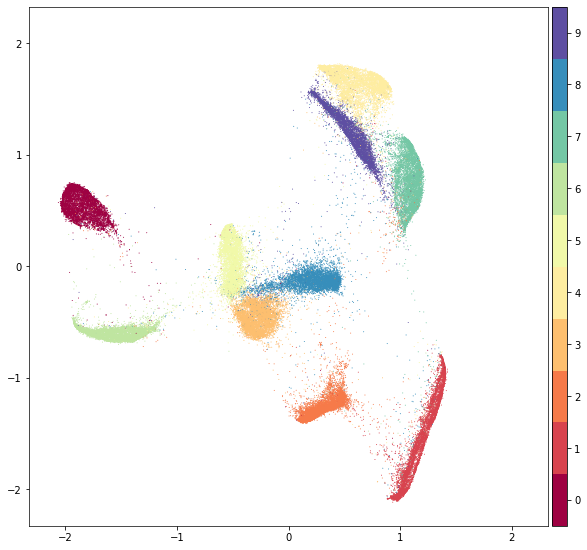

negative weight:  -0.25


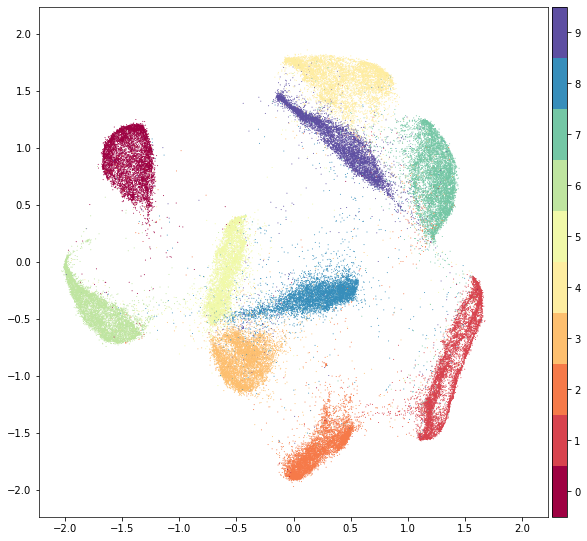

negative weight:  -0.5


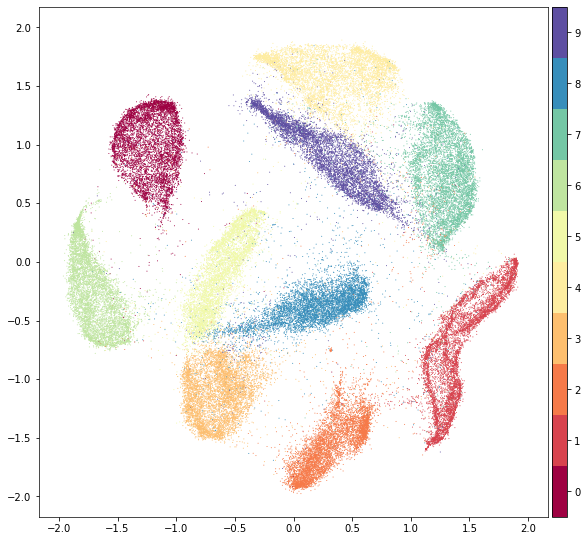

negative weight:  -1.0


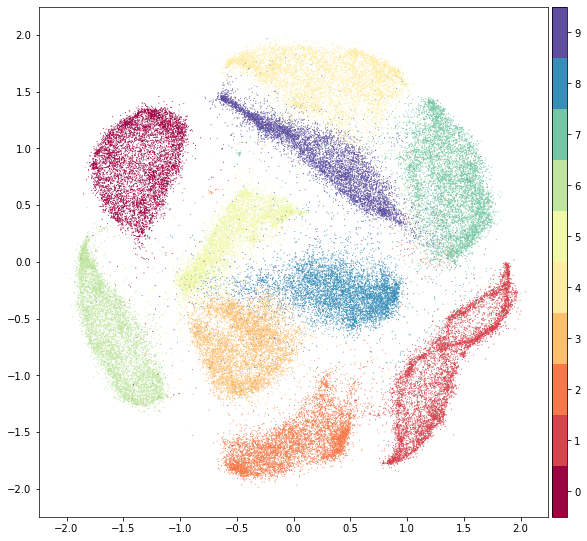

negative weight:  -2.0


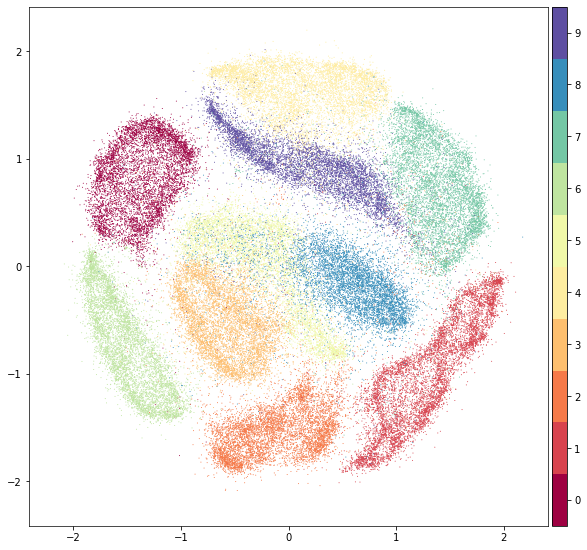

negative weight:  -4.0


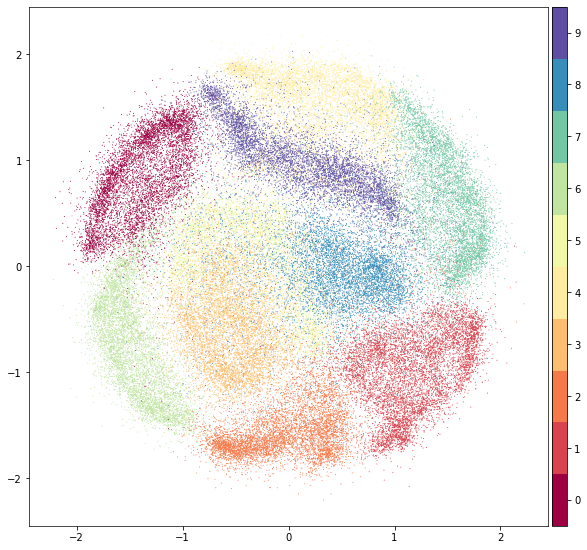

In [8]:
neg_weights = [
    -1/8,
    -1/4,
    -1/2,
    -1.,
    -2.,
    -4.,
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
for neg_weight in neg_weights:
    print('negative weight: ', neg_weight)
    edges, weights = get_edges(knn_graph.edges.shape[0], neg_weight)
    f = pymde.penalties.PushAndPull(
        weights=weights,
        attractive_penalty=pymde.penalties.Log1p,
        repulsive_penalty=pymde.penalties.Log,
    ).to(device)
    std_mde = pymde.MDE(
        images.shape[0],
        embedding_dim=2,
        edges=edges.to(device),
        distortion_function=f,
        constraint=pymde.Standardized(),
    )
    std_mde.embed(X=quadratic_mde.X.to(device))
    std_mde.plot(color_by=digits)
    plt.show()